In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    r2_score
)

In [9]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
sns.set_theme(style="darkgrid")

plt.rcParams.update({
    "axes.titlesize" : 10,
    "axes.labelsize" : 9,
    "xtick.labelsize" : 8,
    "ytick.labelsize" : 8
})

RANDOM_STATE = 42
CSV_PATH = "housing.csv"
TARGET_COL = "median_house_value"

In [10]:
df = pd.read_csv(CSV_PATH)

In [11]:
print("dataframe shape:", df.shape)

dataframe shape: (20640, 10)


In [12]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


In [13]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [60]:
target_col = "median_house_value"
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("target_col:", target_col)
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

target_col: median_house_value
Numerical columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical columns: ['ocean_proximity']


In [16]:
print("\nMissing values per columns:")
print(df.isna().sum())


Missing values per columns:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [17]:
for col in df.columns:
    print(df[col].value_counts().head(20))

longitude
-118.310    162
-118.300    160
-118.290    148
-118.270    144
-118.320    142
-118.280    141
-118.350    140
-118.360    138
-118.190    135
-118.250    128
-118.370    128
-118.200    126
-118.140    125
-118.260    121
-118.130    121
-118.180    120
-118.340    119
-118.210    118
-118.150    116
-118.120    112
Name: count, dtype: int64
latitude
34.060    244
34.050    236
34.080    234
34.070    231
34.040    221
34.090    212
34.020    208
34.100    203
34.030    193
33.930    181
33.940    175
33.970    172
33.990    168
33.880    164
33.980    162
34.110    162
34.160    159
34.120    158
34.150    157
34.010    156
Name: count, dtype: int64
housing_median_age
52.000    1273
36.000     862
35.000     824
16.000     771
17.000     698
34.000     689
26.000     619
33.000     615
18.000     570
25.000     566
32.000     565
37.000     537
15.000     512
19.000     502
27.000     488
24.000     478
30.000     476
28.000     471
20.000     465
29.000     461
Name: coun

In [18]:
duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0


In [19]:
df[num_cols].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.000,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.540,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.330,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.000,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.000,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.000,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.000,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.000,15.000,500001.000


In [20]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.000,-119.570,2.004,-124.350,-121.800,-118.490,-118.010,-114.310
latitude,20640.000,35.632,2.136,32.540,33.930,34.260,37.710,41.950
housing_median_age,20640.000,28.639,12.586,1.000,18.000,29.000,37.000,52.000
total_rooms,20640.000,2635.763,2181.615,2.000,1447.750,2127.000,3148.000,39320.000
total_bedrooms,20433.000,537.871,421.385,1.000,296.000,435.000,647.000,6445.000
population,20640.000,1425.477,1132.462,3.000,787.000,1166.000,1725.000,35682.000
households,20640.000,499.540,382.330,1.000,280.000,409.000,605.000,6082.000
median_income,20640.000,3.871,1.900,0.500,2.563,3.535,4.743,15.000
median_house_value,20640.000,206855.817,115395.616,14999.000,119600.000,179700.000,264725.000,500001.000


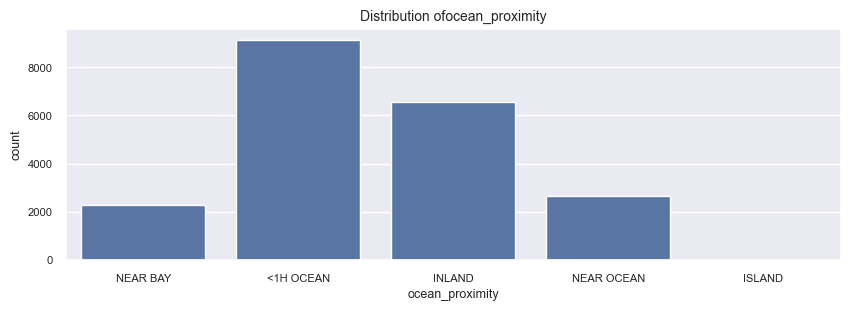

In [21]:
for col in cat_cols:
    plt.figure(figsize=(10 ,3))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of{col}")
    plt.show()


In [22]:
for col in cat_cols:
    print(df[col].value_counts())

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


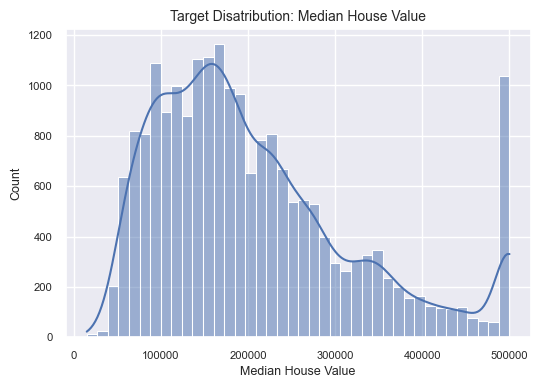

In [23]:
plt.figure(figsize=(6,4))
sns.histplot(df["median_house_value"], bins = 40, kde = True)
plt.title("Target Disatribution: Median House Value")
plt.xlabel("Median House Value")
plt.show()

In [24]:
df[TARGET_COL].value_counts()

median_house_value
500001.000    965
137500.000    122
162500.000    117
112500.000    103
187500.000     93
             ... 
34200.000       1
46200.000       1
352000.000      1
307900.000      1
385200.000      1
Name: count, Length: 3842, dtype: int64

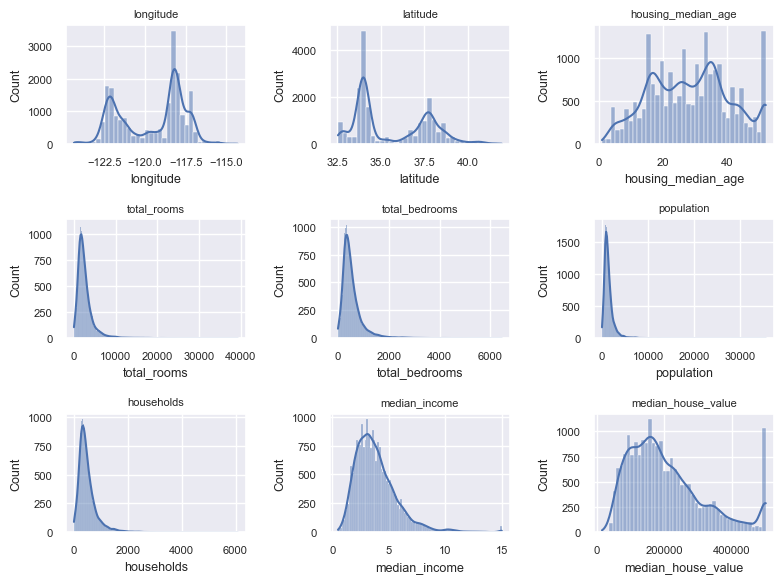

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col, fontsize=8)

plt.tight_layout()
plt.show()

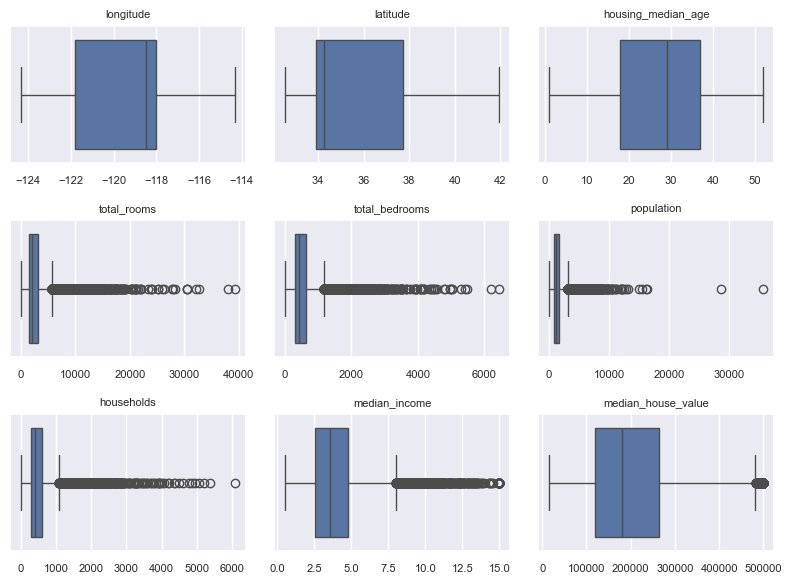

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=8)
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()

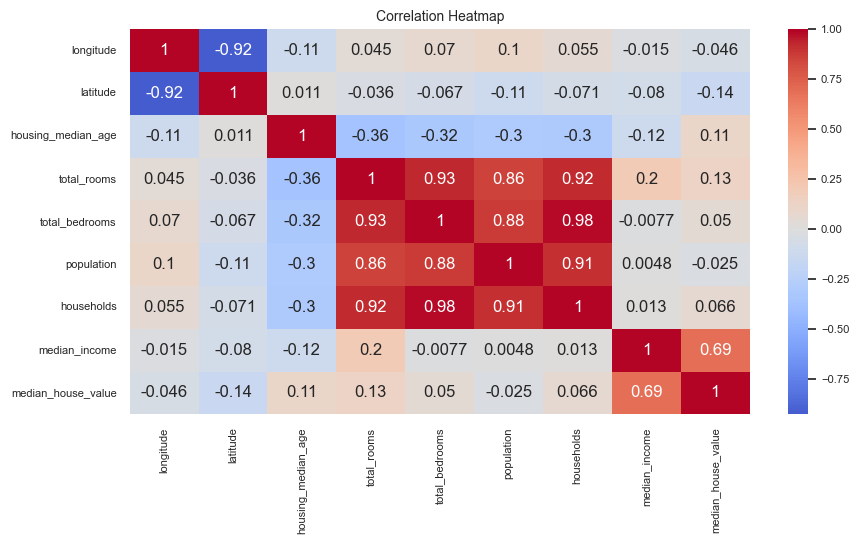

In [27]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap")
plt.show()

In [28]:
corr_with_target = df[num_cols].corr()[TARGET_COL].sort_values(ascending=False)
print("\nCorrelation with target:")
print(corr_with_target)


Correlation with target:
median_house_value    1.000
median_income         0.688
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64


In [29]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [30]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,NEAR BAY


In [31]:
y.head()

0   452600.000
1   358500.000
2   352100.000
3   341300.000
4   342200.000
Name: median_house_value, dtype: float64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [33]:
print("Train shape:", X_train.shape)

print("Test shape:", X_test.shape)

Train shape: (16512, 9)
Test shape: (4128, 9)


In [34]:
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# numerical features - preprocessing steps
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# categorical features - preprocessing steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

Numerical features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Categorical features: ['ocean_proximity']


In [35]:
baseline_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

In [36]:
baseline_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [37]:
train_baseline_pred = baseline_pipe.predict(X_train)
test_baseline_pred = baseline_pipe.predict(X_test)

In [38]:
train_baseline_pred[:5]

array([188628.07724361, 290379.8948687 , 250985.48476349, 146878.07878194,
       165789.41368924])

In [39]:
y_train[:5]

14196   103000.000
8267    382100.000
17445   172600.000
14265    93400.000
2271     96500.000
Name: median_house_value, dtype: float64

In [40]:
train_baseline_rmse = root_mean_squared_error(y_train, train_baseline_pred)
train_baseline_mae = mean_absolute_error(y_train, train_baseline_pred)
train_baseline_r2 = r2_score(y_train, train_baseline_pred)

print("\n=== TRAIN BASELINE METRICS (LinearRegression) ===")
print(f"RMSE: {train_baseline_rmse:.3f}")
print(f"MAE : {train_baseline_mae:.3f}")
print(f"R2  : {train_baseline_r2:.3f}")


=== TRAIN BASELINE METRICS (LinearRegression) ===
RMSE: 68433.937
MAE : 49594.842
R2  : 0.650


In [41]:
test_baseline_rmse = root_mean_squared_error(y_test, test_baseline_pred)
test_baseline_mae = mean_absolute_error(y_test, test_baseline_pred)
test_baseline_r2 = r2_score(y_test, test_baseline_pred)

print("\n=== TEST BASELINE METRICS (LinearRegression) ===")
print(f"RMSE: {test_baseline_rmse:.3f}")
print(f"MAE : {test_baseline_mae:.3f}")
print(f"R2  : {test_baseline_r2:.3f}")


=== TEST BASELINE METRICS (LinearRegression) ===
RMSE: 70059.193
MAE : 50670.489
R2  : 0.625


In [42]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE, max_iter=10000),
    "RandomForest": RandomForestRegressor(),
    "HistGB": HistGradientBoostingRegressor()
}

In [43]:
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

In [44]:
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}

In [45]:
rows = []

for name, model in models.items():
    pipe = Pipeline(
        steps = [
            ("preprocess", preprocess),
            ("model", model)
        ]
    )

    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=1)
    rows.append({
        "model": name,
        "cv_rmse": -scores["test_rmse"].mean(),
        "cv_mae":  -scores["test_mae"].mean(),
        "cv_r2":   -scores["test_r2"].mean()
    })

cv_results = pd.DataFrame(rows).sort_values("cv_rmse")
print("=== CV Model Comparison ===")
print(cv_results)

=== CV Model Comparison ===
              model   cv_rmse    cv_mae  cv_r2
4            HistGB 48214.668 32264.792 -0.826
3      RandomForest 49445.512 32355.611 -0.817
1             Ridge 68595.617 49664.331 -0.648
2             Lasso 68603.233 49667.263 -0.648
0  LinearRegression 68604.163 49667.159 -0.648


In [46]:
cv_results

,model,cv_rmse,cv_mae,cv_r2
4,HistGB,48214.668,32264.792,-0.826
3,RandomForest,49445.512,32355.611,-0.817
1,Ridge,68595.617,49664.331,-0.648
2,Lasso,68603.233,49667.263,-0.648
0,LinearRegression,68604.163,49667.159,-0.648


In [47]:
best_row = cv_results.sort_values("cv_rmse").iloc[0]

best_model_name = best_row["model"]
best_rmse = best_row["cv_rmse"]

print("Best model based on CV RMSE:")
print("Model :", best_model_name)
print("CV RMSE:", best_rmse)

Best model based on CV RMSE:
Model : HistGB
CV RMSE: 48214.66806814011


In [48]:
hgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
    ]
)


In [49]:
param_grid = {
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [None, 3, 6],
    "model__max_leaf_nodes": [15, 31, 63],
    "model__min_samples_leaf": [20, 50, 100],
    "model__l2_regularization": [0.0, 0.1, 1.0]
}

In [50]:
grid = GridSearchCV(
    estimator=hgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

In [51]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__l2_regularization': [0.0, 0.1, ...], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [None, 3, ...], 'model__max_leaf_nodes': [15, 31, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls 

In [52]:
print("\n=== TUNED HistGB (CV) ===")
print("Best CV RMSE:", -grid.best_score_)
print("Best params:", grid.best_params_)


=== TUNED HistGB (CV) ===
Best CV RMSE: 47408.35933729127
Best params: {'model__l2_regularization': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__max_leaf_nodes': 63, 'model__min_samples_leaf': 20}


In [53]:
hgb_best = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", HistGradientBoostingRegressor(
            l2_regularization=0.1,
            learning_rate=0.1,
            max_depth=None,
            max_leaf_nodes=63,
            min_samples_leaf=20
        ))
    ]
)

In [54]:
hgb_best.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [55]:
train_final_pred = hgb_best.predict(X_train)

train_final_rmse = root_mean_squared_error(y_train, train_final_pred)
train_final_mae = mean_absolute_error(y_train, train_final_pred)
train_final_r2 = r2_score(y_train, train_final_pred)

print("\n=== FINAL MODEL (Tuned HGB) Train Performance ===")
print(f"RMSE: {train_final_rmse:.3f}")
print(f"MAE : {train_final_mae:.3f}")
print(f"R2  : {train_final_r2:.3f}")


=== FINAL MODEL (Tuned HGB) Train Performance ===
RMSE: 35620.339
MAE : 24342.901
R2  : 0.905


In [56]:
test_final_pred = hgb_best.predict(X_test)

test_final_rmse = root_mean_squared_error(y_test, test_final_pred)
test_final_mae = mean_absolute_error(y_test, test_final_pred)
test_final_r2 = r2_score(y_test, test_final_pred)

print("\n=== FINAL MODEL (Tuned HGB) Test Performance ===")
print(f"RMSE: {test_final_rmse:.3f}")
print(f"MAE : {test_final_mae:.3f}")
print(f"R2  : {test_final_r2:.3f}")


=== FINAL MODEL (Tuned HGB) Test Performance ===
RMSE: 46365.034
MAE : 30824.450
R2  : 0.836


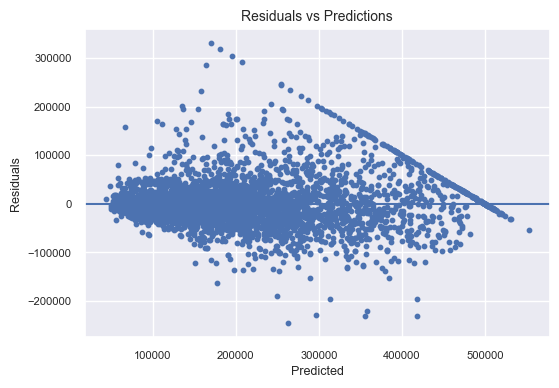

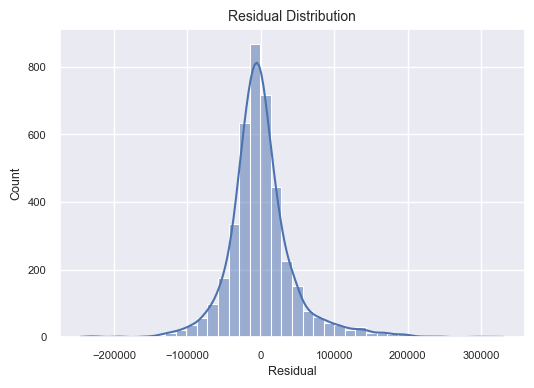

In [57]:
residuals = y_test - test_final_pred

plt.figure(figsize=(6, 4))
plt.scatter(test_final_pred, residuals, s=10)
plt.axhline(0)
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

In [58]:
def predict_house_price(
    model,
    longitude: float,
    latitude: float,
    housing_median_age: float,
    total_rooms: float,
    total_bedrooms: float,
    population: float,
    households: float,
    median_income: float,
    ocean_proximity: str
) -> float:
    """
    Predict median_house_value for one new house.
    total_bedrooms can be np.nan (pipeline will impute).
    """
    new_row = pd.DataFrame([{
        "longitude": longitude,
        "latitude": latitude,
        "housing_median_age": housing_median_age,
        "total_rooms": total_rooms,
        "total_bedrooms": total_bedrooms,
        "population": population,
        "households": households,
        "median_income": median_income,
        "ocean_proximity": ocean_proximity
    }])

    return float(model.predict(new_row)[0])

In [59]:
example_pred = predict_house_price(
    model=hgb_best,
    longitude=-122.230,
    latitude=37.880,
    housing_median_age=41,
    total_rooms=880,
    total_bedrooms=129,
    population=322,
    households=126,
    median_income=8.3252,
    ocean_proximity="NEAR BAY"
 )

print("\nExample prediction:", round(example_pred, 2))


Example prediction: 459897.18
